In [1]:
from sklearn.metrics import r2_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from torch.utils.data import Dataset, DataLoader, random_split
from torch.autograd import Variable
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
import torchvision
import torch
from FeatureEngineeringUtils.btc_feature_engineering_utils import TrainTestValidationLoader
from numpy.random import permutation
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd 
import numpy as np
import random 
import time
import os
from ModelingUtils.models import CandlesDataset, ConvCandlesDataset, DeepLSTMNet2, WideDeepLSTMNet, ConvWideDeepLSTMNet, train_epoch, test_epoch, save_model_on_validation_improvement, \
                                 load_model, predict, VariationalAutoencoder, FullyConnectedNet, vae_train_epoch, vae_test_epoch, save_vae_on_validation_improvement, \
                                 load_encoder, evaluate, plot_stats_box

In [2]:
data_loader = TrainTestValidationLoader('btc_15m_for_target1_1', target='target1', training_portion=0.75, validation_portion=0.4, original_time_frame=240)
x_train = data_loader.x_train
x_test = data_loader.x_test
x_val = data_loader.x_val
print(x_train.iloc[-1, :].name)
print(x_test.iloc[0, :].name)
print(x_val.iloc[0, :].name)
print(x_val.iloc[-1, :].name)

2020-11-30 07:30:00
2020-11-30 07:45:00
2021-07-24 23:45:00
2021-12-31 20:00:00


## 0) Deep_Net

In [2]:
data_loader = TrainTestValidationLoader('btc_4h_for_target1_1', target='target1', training_portion=0.75, validation_portion=0.4, original_time_frame=240)

train_features, train_labels = data_loader.get_reframed_train_data()
train_dataset = CandlesDataset(train_features, train_labels.reshape(-1, 1))

test_features, test_labels = data_loader.get_reframed_test_data()
test_dataset = CandlesDataset(test_features, test_labels.reshape(-1, 1))

val_features, val_labels = data_loader.get_reframed_val_data()
val_dataset = CandlesDataset(val_features, val_labels.reshape(-1, 1))

batch_size = 128

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [3]:
torch.manual_seed(1)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')


input_dim = np.shape(train_features)[2]
dn = DeepLSTMNet2(device=device)

loss_fn1 = nn.MSELoss(reduction='mean')
loss_fn2 = nn.L1Loss(reduction='mean')

lr = 16e-4 
adam_optimizer = torch.optim.Adam(dn.parameters(), lr=lr, weight_decay=4e-4)

dn.to(device, dtype=torch.double)

Selected device: cuda


DeepLSTMNet2(
  (l1): LSTMCell(74, 110)
  (l2): LSTMCell(110, 80)
  (l3): LSTMCell(80, 60)
  (l4): LSTMCell(60, 30)
  (fc): Linear(in_features=30, out_features=1, bias=True)
)

In [4]:
best_loss = np.inf
patience = 5
last_improvement = 0

num_epochs = 50
epoch = 1
flag = True
while flag is True:
    start_time = time.time()
    
    total_loss_train = train_epoch(dn, device, train_loader, loss_fn1, loss_fn2, optimizer=adam_optimizer)
    total_loss_test = test_epoch(dn, device, test_loader, loss_fn1, loss_fn2)
    
    if epoch % 1 == 0:
        print('\n EPOCH {}/{} \t total_train {:.7f} \t total_test {:.7f} \t execution time: {:.0f}'.format(epoch, num_epochs, total_loss_train, total_loss_test, (time.time() - start_time)))
    
    if total_loss_test < best_loss:
        save_model_on_validation_improvement(dn, adam_optimizer, epoch, 'dn1')
        best_loss = total_loss_test
        last_improvement = epoch
    
    if epoch - last_improvement >= patience:
        flag = False
    
    if epoch >= num_epochs:
        flag = False
    epoch = epoch + 1


 EPOCH 1/50 	 total_train 0.0078612 	 total_test 0.0082154 	 execution time: 9

 EPOCH 2/50 	 total_train 0.0068181 	 total_test 0.0062425 	 execution time: 5

 EPOCH 3/50 	 total_train 0.0059675 	 total_test 0.0060123 	 execution time: 5

 EPOCH 4/50 	 total_train 0.0057367 	 total_test 0.0059963 	 execution time: 5

 EPOCH 5/50 	 total_train 0.0056249 	 total_test 0.0060779 	 execution time: 5

 EPOCH 6/50 	 total_train 0.0055920 	 total_test 0.0061033 	 execution time: 5

 EPOCH 7/50 	 total_train 0.0055536 	 total_test 0.0068020 	 execution time: 5

 EPOCH 8/50 	 total_train 0.0054951 	 total_test 0.0063595 	 execution time: 5

 EPOCH 9/50 	 total_train 0.0054606 	 total_test 0.0064318 	 execution time: 5


In [5]:
model, adam_optimizer = load_model('torch_models//dn1.pth', dn, adam_optimizer)

In [6]:
train_preds = predict(model, train_dataset, device)

100%|█████████████████████████████████████████████████████████████████████████████| 7118/7118 [00:52<00:00, 134.90it/s]


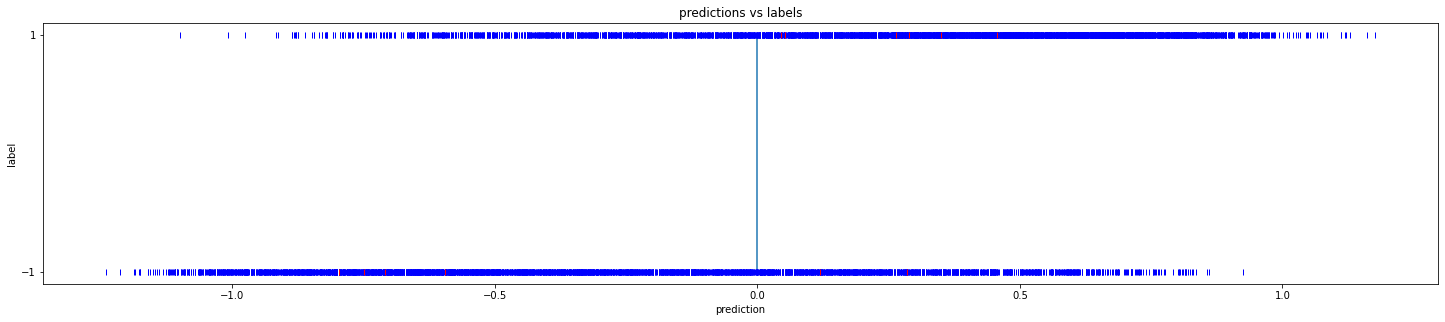

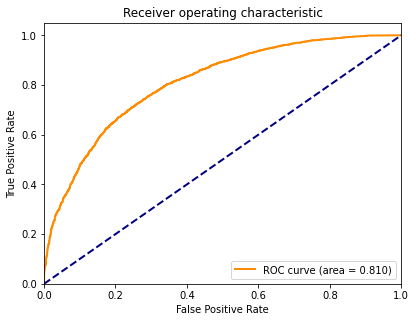

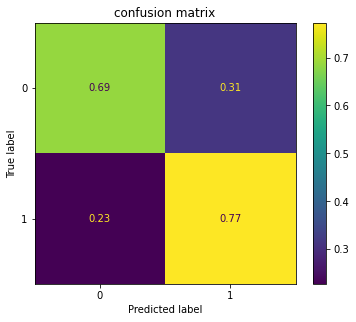

accuracy: 0.7320876650744591
f_score_rise: 0.7527550888110981, precision_rise: 0.7341932220536166, recall_rise: 0.7722798616653366
f_score_fall: 0.7076498543614901, precision_fall: 0.729456384323641, recall_fall: 0.6871092587079488


(0.8100770911546931, 0.7320876650744591)

In [7]:
evaluate(train_labels.reshape(-1, 1), train_preds.reshape(-1, 1), continuous=False, separator=0, multiclass=False)

In [8]:
test_preds = predict(model, test_dataset, device)

100%|█████████████████████████████████████████████████████████████████████████████| 1420/1420 [00:10<00:00, 132.88it/s]


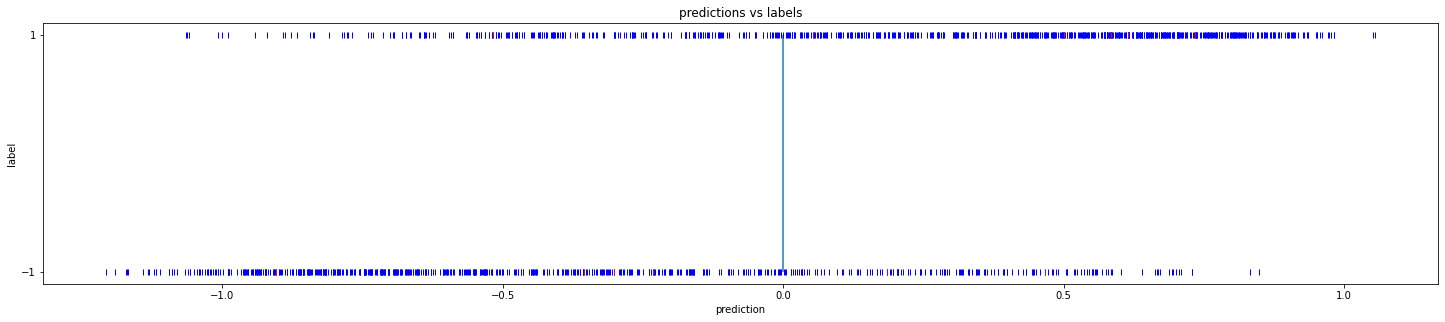

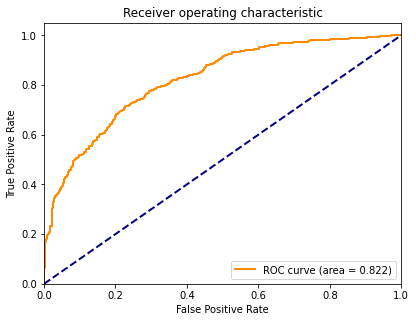

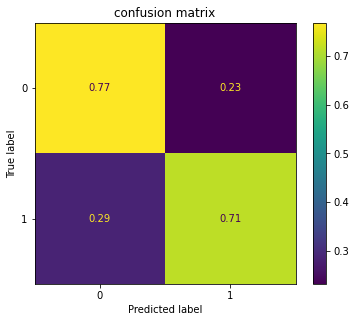

accuracy: 0.7387323943661972
f_score_rise: 0.7474472430224642, precision_rise: 0.7842857142857143, recall_rise: 0.7139141742522757
f_score_fall: 0.7293946024799417, precision_fall: 0.6944444444444444, recall_fall: 0.7680491551459293


(0.8218325712767595, 0.7387323943661972)

In [9]:
evaluate(test_labels.reshape(-1, 1), test_preds.reshape(-1, 1), continuous=False, separator=0, multiclass=False)

In [10]:
val_preds = predict(model, val_dataset, device)

100%|███████████████████████████████████████████████████████████████████████████████| 960/960 [00:07<00:00, 130.38it/s]


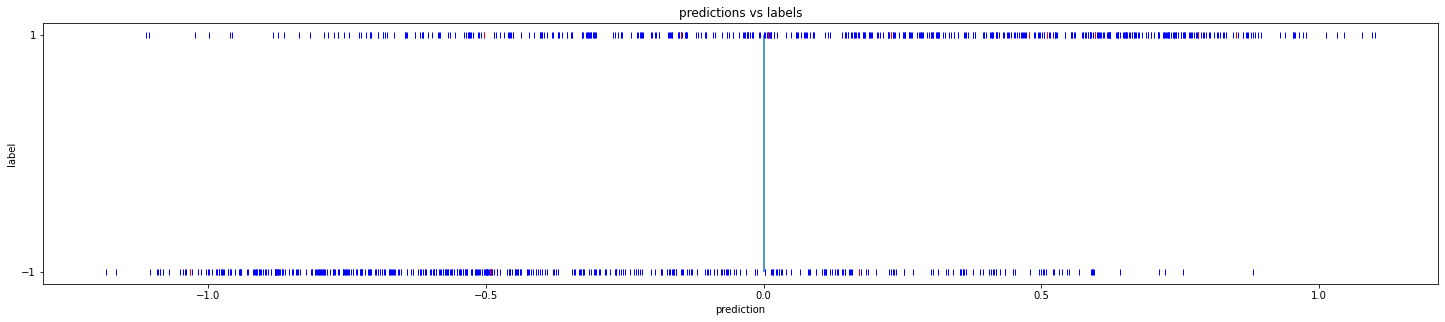

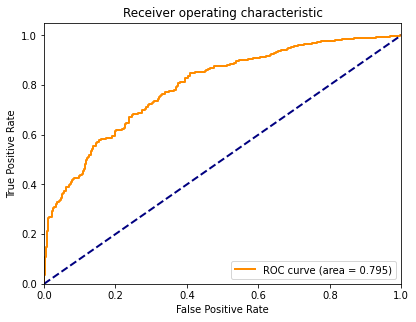

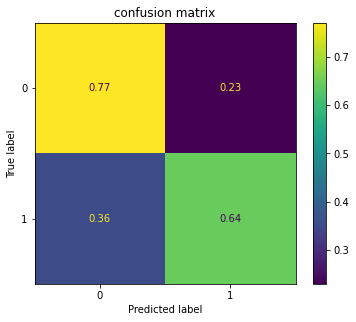

accuracy: 0.7052083333333333
f_score_rise: 0.6927252985884907, precision_rise: 0.7488262910798122, recall_rise: 0.6444444444444445
f_score_fall: 0.7167167167167168, precision_fall: 0.6704119850187266, recall_fall: 0.7698924731182796


(0.7952123384381449, 0.7052083333333333)

In [11]:
evaluate(val_labels.reshape(-1, 1), val_preds.reshape(-1, 1), continuous=False, separator=0, multiclass=False)

100%|███████████████████████████████████████████████████████████████████████████████| 960/960 [00:07<00:00, 134.00it/s]


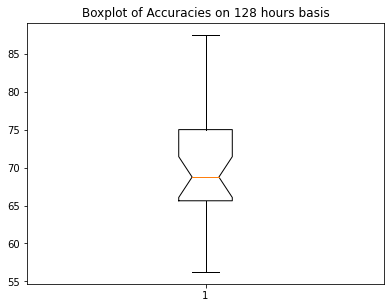

In [12]:
val_preds = predict(model, val_dataset, device)
scores = plot_stats_box(val_dataset.targets, val_preds.reshape(-1, 1), add_plot=None)

## 1) WDnet

In [2]:
data_loader = TrainTestValidationLoader('btc_4h_for_target1_1', target='target1', training_portion=0.75, validation_portion=0.4, original_time_frame=240)

train_features, train_labels = data_loader.get_reframed_train_data()
train_dataset = CandlesDataset(train_features, train_labels.reshape(-1, 1))

test_features, test_labels = data_loader.get_reframed_test_data()
test_dataset = CandlesDataset(test_features, test_labels.reshape(-1, 1))

val_features, val_labels = data_loader.get_reframed_val_data()
val_dataset = CandlesDataset(val_features, val_labels.reshape(-1, 1))

batch_size = 128

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [3]:
torch.manual_seed(1)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')


input_dim = np.shape(train_features)[2]
wdn = WideDeepLSTMNet(input_dim=input_dim, device=device)

loss_fn1 = nn.MSELoss(reduction='mean')
loss_fn2 = nn.L1Loss(reduction='mean')

lr = 16e-4 
adam_optimizer = torch.optim.Adam(wdn.parameters(), lr=lr, weight_decay=4e-4)

wdn.to(device, dtype=torch.double)

Selected device: cuda


WideDeepLSTMNet(
  (deep_lstm): DeepLSTMNet(
    (l1): LSTMCell(74, 90)
    (l2): LSTMCell(90, 66)
    (l3): LSTMCell(66, 48)
    (l4): LSTMCell(48, 24)
    (fc): Linear(in_features=24, out_features=1, bias=True)
  )
  (wide_lstm): WideLSTMNet(
    (lstm): LSTM(74, 110, batch_first=True)
    (fc): Linear(in_features=110, out_features=1, bias=True)
  )
  (fc): Linear(in_features=2, out_features=1, bias=True)
)

In [4]:
best_loss = np.inf
patience = 5
last_improvement = 0

num_epochs = 50
epoch = 1
flag = True
while flag is True:
    start_time = time.time()
    
    total_loss_train = train_epoch(wdn, device, train_loader, loss_fn1, loss_fn2, optimizer=adam_optimizer)
    total_loss_test = test_epoch(wdn, device, test_loader, loss_fn1, loss_fn2)
    
    if epoch % 1 == 0:
        print('\n EPOCH {}/{} \t total_train {:.7f} \t total_test {:.7f} \t execution time: {:.0f}'.format(epoch, num_epochs, total_loss_train, total_loss_test, (time.time() - start_time)))
    
    if total_loss_test < best_loss:
        save_model_on_validation_improvement(wdn, adam_optimizer, epoch, 'wdn1')
        best_loss = total_loss_test
        last_improvement = epoch
    
    if epoch - last_improvement >= patience:
        flag = False
    
    if epoch >= num_epochs:
        flag = False
    epoch = epoch + 1


 EPOCH 1/50 	 total_train 0.0070853 	 total_test 0.0062686 	 execution time: 7

 EPOCH 2/50 	 total_train 0.0059238 	 total_test 0.0060529 	 execution time: 7

 EPOCH 3/50 	 total_train 0.0057250 	 total_test 0.0058716 	 execution time: 7

 EPOCH 4/50 	 total_train 0.0056456 	 total_test 0.0058040 	 execution time: 7

 EPOCH 5/50 	 total_train 0.0056649 	 total_test 0.0058610 	 execution time: 7

 EPOCH 6/50 	 total_train 0.0055550 	 total_test 0.0062279 	 execution time: 7

 EPOCH 7/50 	 total_train 0.0054901 	 total_test 0.0057803 	 execution time: 7

 EPOCH 8/50 	 total_train 0.0054839 	 total_test 0.0059689 	 execution time: 7

 EPOCH 9/50 	 total_train 0.0054544 	 total_test 0.0065688 	 execution time: 7

 EPOCH 10/50 	 total_train 0.0054118 	 total_test 0.0064454 	 execution time: 7

 EPOCH 11/50 	 total_train 0.0053863 	 total_test 0.0060278 	 execution time: 7

 EPOCH 12/50 	 total_train 0.0053281 	 total_test 0.0059102 	 execution time: 7


In [4]:
model, adam_optimizer = load_model('torch_models//wdn1.pth', wdn, adam_optimizer)

In [5]:
train_preds = predict(model, train_dataset, device)

100%|█████████████████████████████████████████████████████████████████████████████| 7118/7118 [01:01<00:00, 115.76it/s]


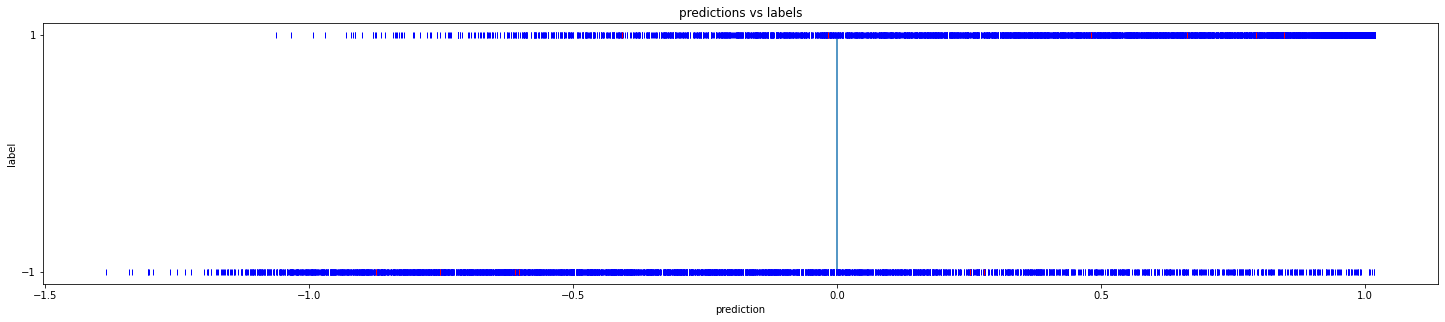

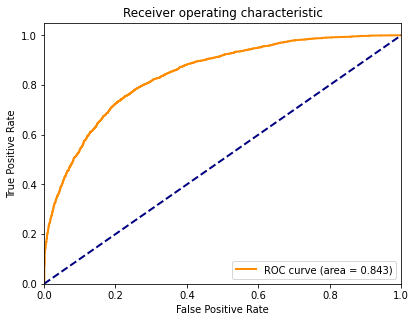

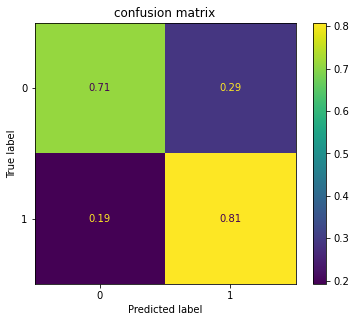

accuracy: 0.7615903343635853
f_score_rise: 0.7815677693396833, precision_rise: 0.7571072319201995, recall_rise: 0.8076616121308858
f_score_fall: 0.737590845832689, precision_fall: 0.7673745173745173, recall_fall: 0.7100327478416195


(0.8425066334792727, 0.7615903343635853)

In [6]:
evaluate(train_labels.reshape(-1, 1), train_preds.reshape(-1, 1), continuous=False, separator=0, multiclass=False)

In [7]:
test_preds = predict(model, test_dataset, device)

100%|█████████████████████████████████████████████████████████████████████████████| 1420/1420 [00:11<00:00, 119.01it/s]


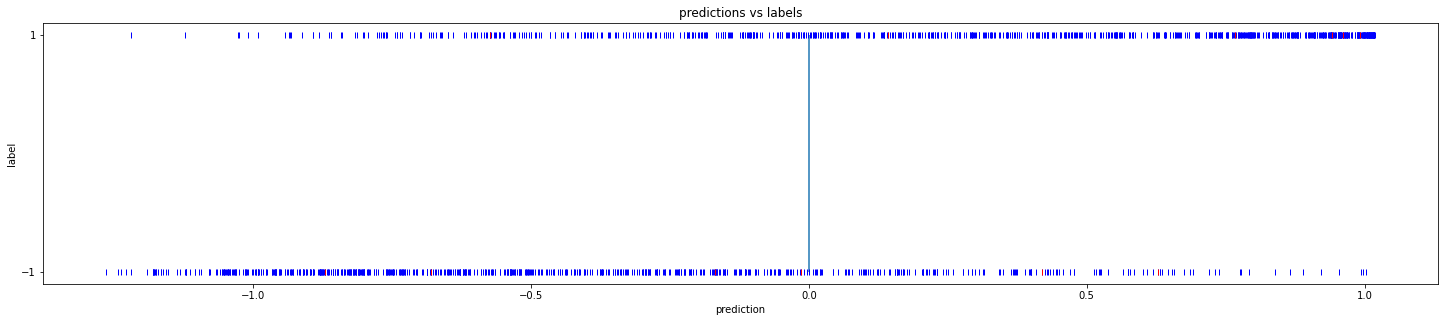

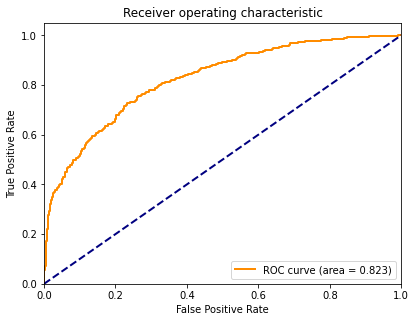

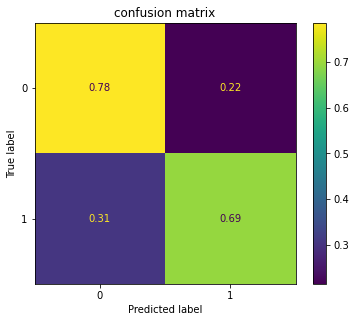

accuracy: 0.7359154929577465
f_score_rise: 0.74012474012474, precision_rise: 0.7922848664688428, recall_rise: 0.694408322496749
f_score_fall: 0.7315676449534716, precision_fall: 0.6849865951742627, recall_fall: 0.7849462365591398


(0.823170914407963, 0.7359154929577465)

In [8]:
evaluate(test_labels.reshape(-1, 1), test_preds.reshape(-1, 1), continuous=False, separator=0, multiclass=False)

In [9]:
val_preds = predict(model, val_dataset, device)

100%|███████████████████████████████████████████████████████████████████████████████| 960/960 [00:08<00:00, 118.33it/s]


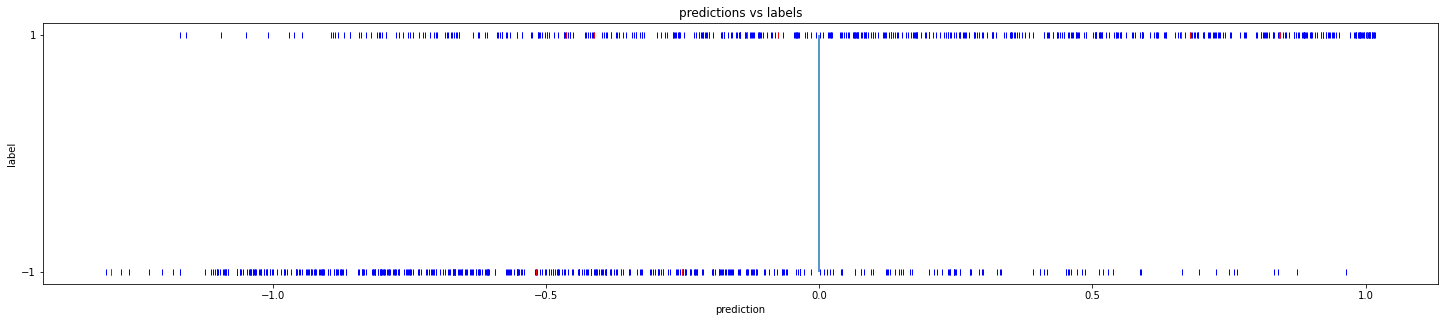

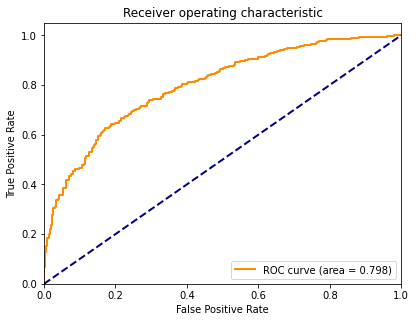

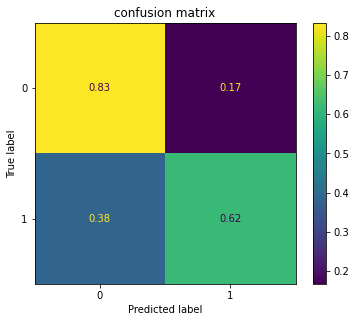

accuracy: 0.7208333333333333
f_score_rise: 0.6947608200455581, precision_rise: 0.7963446475195822, recall_rise: 0.6161616161616161
f_score_fall: 0.7428023032629559, precision_fall: 0.6707105719237435, recall_fall: 0.832258064516129


(0.79788421852938, 0.7208333333333333)

In [10]:
evaluate(val_labels.reshape(-1, 1), val_preds.reshape(-1, 1), continuous=False, separator=0, multiclass=False)

100%|███████████████████████████████████████████████████████████████████████████████| 960/960 [00:08<00:00, 118.69it/s]


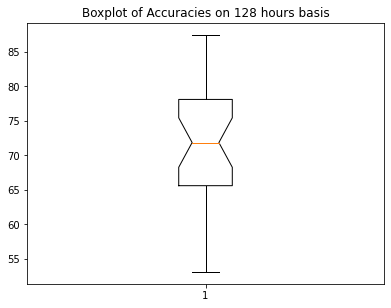

In [11]:
val_preds = predict(model, val_dataset, device)
scores = plot_stats_box(val_dataset.targets, val_preds.reshape(-1, 1), add_plot=None)

## 2) CWDNet

### btc_4h

In [2]:
data_loader = TrainTestValidationLoader('btc_4h_for_target1_1', target='target1', training_portion=0.75, validation_portion=0.4, original_time_frame=240)

train_features, train_labels = data_loader.get_reframed_train_data()
train_dataset = ConvCandlesDataset(train_features, train_labels.reshape(-1, 1))

test_features, test_labels = data_loader.get_reframed_test_data()
test_dataset = ConvCandlesDataset(test_features, test_labels.reshape(-1, 1))

val_features, val_labels = data_loader.get_reframed_val_data()
val_dataset = ConvCandlesDataset(val_features, val_labels.reshape(-1, 1))

batch_size = 127

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [3]:
torch.manual_seed(1)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')


input_dim = np.shape(train_features)[2]
cwdn = ConvWideDeepLSTMNet(input_dim=input_dim, device=device)

loss_fn1 = nn.MSELoss(reduction='mean')
loss_fn2 = nn.L1Loss(reduction='mean')

lr = 16e-4 
adam_optimizer = torch.optim.Adam(cwdn.parameters(), lr=lr, weight_decay=5e-4)

cwdn.to(device, dtype=torch.double)

Selected device: cuda


ConvWideDeepLSTMNet(
  (conv_net): ConvNet74(
    (conv1): Conv2d(1, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 0))
    (max1): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=(0, 0), dilation=1, ceil_mode=False)
    (batch1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(48, 64, kernel_size=(3, 5), stride=(1, 1), padding=(1, 0))
    (max2): MaxPool2d(kernel_size=(1, 3), stride=(1, 1), padding=(0, 0), dilation=1, ceil_mode=False)
    (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 64, kernel_size=(3, 7), stride=(1, 1), padding=(1, 0))
    (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv3d(1, 1, kernel_size=(64, 1, 1), stride=(1, 1, 1))
    (batch4): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deep_lstm): DeepLSTMNet(
    (l1): LSTMCell(12, 90)
    (l2): LS

In [4]:
best_loss = np.inf
patience = 5
last_improvement = 0

num_epochs = 50
epoch = 1
flag = True
while flag is True:
    start_time = time.time()
    
    total_loss_train = train_epoch(cwdn, device, train_loader, loss_fn1, loss_fn2, optimizer=adam_optimizer)
    total_loss_test = test_epoch(cwdn, device, test_loader, loss_fn1, loss_fn2)
    
    if epoch % 1 == 0:
        print('\n EPOCH {}/{} \t total_train {:.7f} \t total_test {:.7f} \t execution time: {:.0f}'.format(epoch, num_epochs, total_loss_train, total_loss_test, (time.time() - start_time)))
    
    if total_loss_test < best_loss:
        save_model_on_validation_improvement(cwdn, adam_optimizer, epoch, 'cwdn2')
        best_loss = total_loss_test
        last_improvement = epoch
    
    if epoch - last_improvement >= patience:
        flag = False
    
    if epoch >= num_epochs:
        flag = False
    epoch = epoch + 1


 EPOCH 1/50 	 total_train 0.0069777 	 total_test 0.0062722 	 execution time: 45

 EPOCH 2/50 	 total_train 0.0061200 	 total_test 0.0061239 	 execution time: 45

 EPOCH 3/50 	 total_train 0.0057996 	 total_test 0.0058619 	 execution time: 45

 EPOCH 4/50 	 total_train 0.0056408 	 total_test 0.0068700 	 execution time: 45

 EPOCH 5/50 	 total_train 0.0057282 	 total_test 0.0065520 	 execution time: 45

 EPOCH 6/50 	 total_train 0.0055572 	 total_test 0.0060682 	 execution time: 45

 EPOCH 7/50 	 total_train 0.0055696 	 total_test 0.0061954 	 execution time: 45

 EPOCH 8/50 	 total_train 0.0055611 	 total_test 0.0067270 	 execution time: 45


In [5]:
model, adam_optimizer = load_model('torch_models//cwdn2.pth', cwdn, adam_optimizer)

In [10]:
train_preds = predict(model, train_dataset, device)

100%|██████████████████████████████████████████████████████████████████████████████| 7118/7118 [01:26<00:00, 81.97it/s]


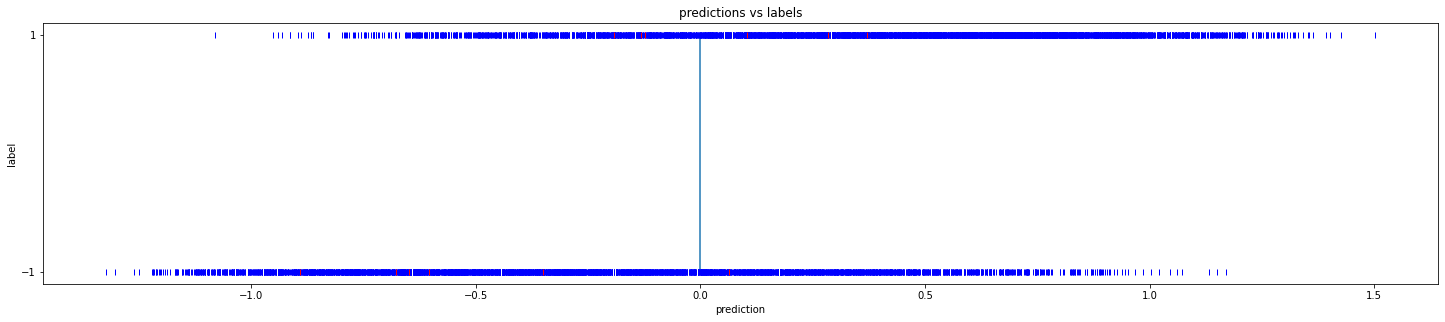

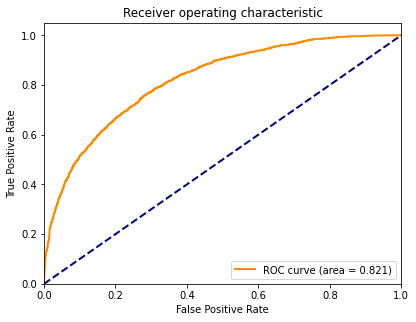

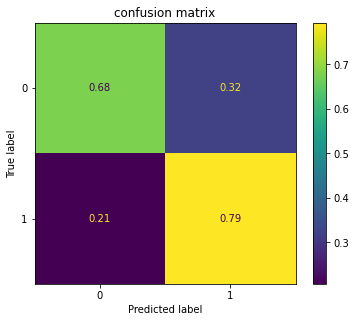

accuracy: 0.7379881989322844
f_score_rise: 0.7616613418530352, precision_rise: 0.7329070339399901, recall_rise: 0.7927640329874966
f_score_fall: 0.7090937451255654, precision_fall: 0.7447575360419397, recall_fall: 0.6766894909199166


(0.8205209353263194, 0.7379881989322844)

In [11]:
evaluate(train_labels.reshape(-1, 1), train_preds.reshape(-1, 1), continuous=False, separator=0, multiclass=False)

In [6]:
test_preds = predict(model, test_dataset, device)

100%|██████████████████████████████████████████████████████████████████████████████| 1420/1420 [00:17<00:00, 82.16it/s]


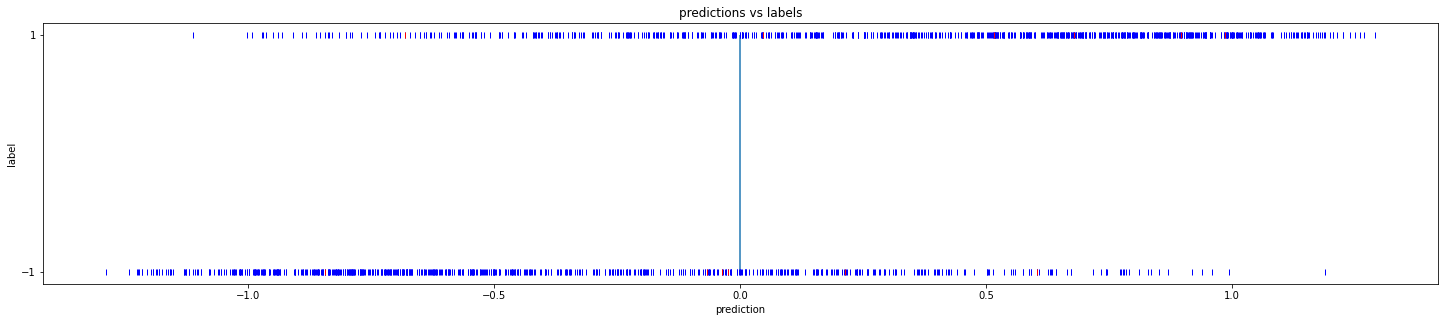

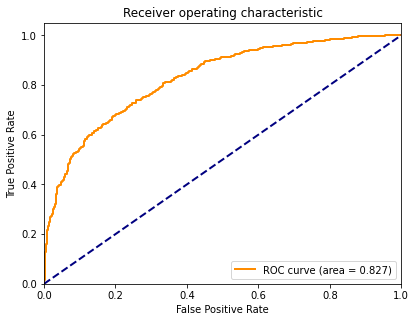

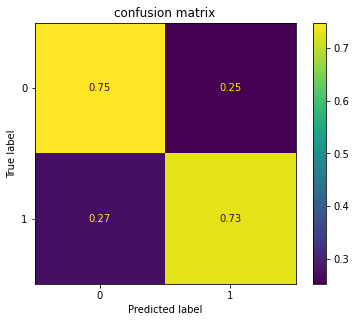

accuracy: 0.7373239436619718
f_score_rise: 0.7501674480910918, precision_rise: 0.7734806629834254, recall_rise: 0.7282184655396619
f_score_fall: 0.7230883444691909, precision_fall: 0.6997126436781609, recall_fall: 0.7480798771121352


(0.8272898152087715, 0.7373239436619718)

In [7]:
evaluate(test_labels.reshape(-1, 1), test_preds.reshape(-1, 1), continuous=False, separator=0, multiclass=False)

In [8]:
val_preds = predict(model, val_dataset, device)

100%|████████████████████████████████████████████████████████████████████████████████| 960/960 [00:11<00:00, 81.91it/s]


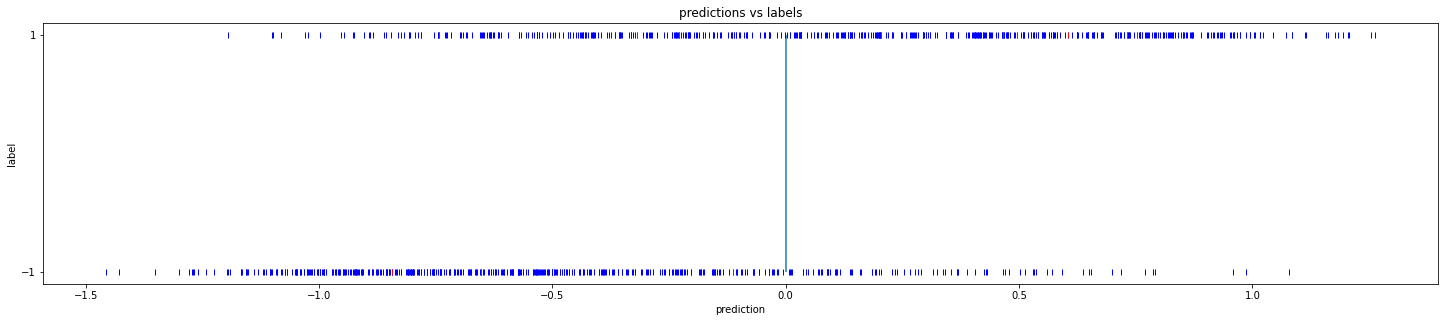

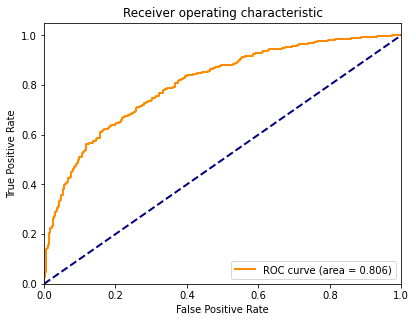

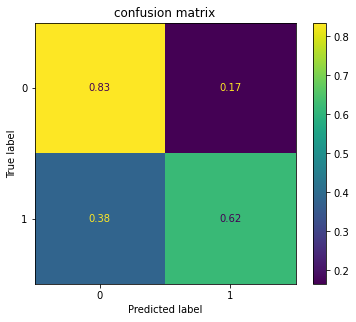

accuracy: 0.7229166666666667
f_score_rise: 0.6970387243735763, precision_rise: 0.7989556135770235, recall_rise: 0.6181818181818182
f_score_fall: 0.7447216890595009, precision_fall: 0.6724436741767764, recall_fall: 0.8344086021505376


(0.8056956663408276, 0.7229166666666667)

In [9]:
evaluate(val_labels.reshape(-1, 1), val_preds.reshape(-1, 1), continuous=False, separator=0, multiclass=False)

### btc_1h

In [ ]:
data_loader = TrainTestValidationLoader('btc_4h_for_target1_1', target='target1', training_portion=0.75, validation_portion=0.4, original_time_frame=240)

train_features, train_labels = data_loader.get_reframed_train_data()
train_dataset = ConvCandlesDataset(train_features, train_labels.reshape(-1, 1))

test_features, test_labels = data_loader.get_reframed_test_data()
test_dataset = ConvCandlesDataset(test_features, test_labels.reshape(-1, 1))

val_features, val_labels = data_loader.get_reframed_val_data()
val_dataset = ConvCandlesDataset(val_features, val_labels.reshape(-1, 1))

batch_size = 127

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
torch.manual_seed(1)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')


input_dim = np.shape(train_features)[2]
cwdn = ConvWideDeepLSTMNet(input_dim=input_dim, device=device)

loss_fn1 = nn.MSELoss(reduction='mean')
loss_fn2 = nn.L1Loss(reduction='mean')

lr = 16e-4 
adam_optimizer = torch.optim.Adam(cwdn.parameters(), lr=lr, weight_decay=5e-4)

cwdn.to(device, dtype=torch.double)

In [ ]:
best_loss = np.inf
patience = 5
last_improvement = 0

num_epochs = 50
epoch = 1
flag = True
while flag is True:
    start_time = time.time()
    
    total_loss_train = train_epoch(cwdn, device, train_loader, loss_fn1, loss_fn2, optimizer=adam_optimizer)
    total_loss_test = test_epoch(cwdn, device, test_loader, loss_fn1, loss_fn2)
    
    if epoch % 1 == 0:
        print('\n EPOCH {}/{} \t total_train {:.7f} \t total_test {:.7f} \t execution time: {:.0f}'.format(epoch, num_epochs, total_loss_train, total_loss_test, (time.time() - start_time)))
    
    if total_loss_test < best_loss:
        save_model_on_validation_improvement(cwdn, adam_optimizer, epoch, 'cwdn2')
        best_loss = total_loss_test
        last_improvement = epoch
    
    if epoch - last_improvement >= patience:
        flag = False
    
    if epoch >= num_epochs:
        flag = False
    epoch = epoch + 1

In [ ]:
model, adam_optimizer = load_model('torch_models//cwdn2.pth', cwdn, adam_optimizer)

In [ ]:
train_preds = predict(model, train_dataset, device)

In [ ]:
evaluate(train_labels.reshape(-1, 1), train_preds.reshape(-1, 1), continuous=False, separator=0, multiclass=False)

In [ ]:
test_preds = predict(model, test_dataset, device)

save conv net

In [2]:
torch.manual_seed(1)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

cwdn = ConvWideDeepLSTMNet(input_dim=74, device=device)
cwdn = load_model('torch_models//cwdn2.pth', cwdn)
conv_net = cwdn.conv_net

state = {'state_dict': conv_net.state_dict()}
torch.save(state, f'torch_models//conv_net_240.pth')

Selected device: cuda
